# 지도학습- 거리기반(KNN)

In [4]:
from hossam import *

# 파이썬 기본 라이브러리
from pandas import DataFrame, concat, get_dummies
import numpy as np
from itertools import combinations

# 시각화 라이브러리
from matplotlib import pyplot as plt
import seaborn as sb

# 통계 라이브러리
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova
from scipy.stats import (
    normaltest,
    bartlett,
    levene,
    ttest_ind,
    pearsonr,
    spearmanr,
    shapiro,
    jarque_bera,
    t,
    f,
)

# 머신러닝 라이브러리
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

# 학습모델
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    SGDRegressor
)

# 성능 평가 지표 모듈
from sklearn.metrics import(
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# 확률적 경사 하강법
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

In [5]:
origin = load_data('restaurant_sales_preprocessed')
origin.set_index('date', inplace = True)
origin['holiday'] = origin['holiday'].astype('category')
origin['weekend'] = origin['weekend'].astype('category')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
데이터셋 크기: (353, 9)
열 개수: 9
행 개수: 353
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sales           353 non-null    float64 
 1   visitors        353 non-null    int64   
 2   avg_price       353 non-null    int64   
 3   marketing_cost  353 non-null    float64 
 4   delivery_ratio  353 non-null    float64 
 5   rain_mm         353 non-null    float64 
 6   temperature     353 non-null    float64 
 7   holiday         353 non-null    category
 8   weekend         353 non-null    category
dtypes: category(2), float64(5), int64(2)
memory usage: 23.0 KB
None


,sales,visitors,avg_price,marketing_cost,delivery_ratio,rain_mm,temperature,holiday,weekend
date,,,,,,,,,
2024-01-01,16.169,122,14490,9.200,0.480,1.946,5.200,0,0
2024-01-02,16.005,106,11880,9.149,0.480,2.079,11.100,0,0
2024-01-03,16.354,120,18010,8.666,0.430,2.595,12.900,1,0
2024-01-04,16.082,115,11160,8.748,0.410,2.028,12.900,0,0
2024-01-05,16.113,124,15480,8.594,0.510,2.197,11.000,0,0


## 1. 훈련, 검증 데이터 분리

In [6]:
df = origin

yname = 'sales'
x = df.drop(columns = [yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.25, random_state = 52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

## 2. 모형 적합

In [7]:
%%time

# 파이프라인 정의
pipe = Pipeline(
    [('scaler', StandardScaler()), ('model', KNeighborsRegressor())]
)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    # 핵심 파라미터
    'model__n_neighbors': [3, 5, 7, 9, 15, 25],
    'model__weights': ['uniform', 'distance'],
    # 거리 정의
    'model__metric': ['euclidean','manhattan','minkowski'],
    'model__p': [
        1,
        2
    ], # p=1: Manhattan, p=2: Eculidean -> metric ='minkowski'일 때만 p 의미 있음    
    # 탐색 알고리즘 / 성능
    'model__algorithm': ['auto', 'ball_tree','kd_tree'],
    'model__leaf_size': [20, 30, 40]
}

# 그리드 서치 객체 생성
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, scoring = 'r2', n_jobs = -1)

gs.fit(x_train, y_train)

# 최적 모델
best_model = gs.best_estimator_

# 결과 확인
print('Best params:', gs.best_params_)
print('CV best score:', gs.best_score_)

Best params: {'model__algorithm': 'auto', 'model__leaf_size': 20, 'model__metric': 'euclidean', 'model__n_neighbors': 15, 'model__p': 1, 'model__weights': 'distance'}
CV best score: 0.6444866391028172
CPU times: total: 1.27 s
Wall time: 8.6 s


## 3. 성능평가 지표

In [8]:
y_pred = best_model.predict(x_test)

result_df = DataFrame(
    {
        '결정계수(R2)': r2_score(y_test, y_pred),
        '평균절대오차(MAE)': mean_absolute_error(y_test, y_pred),
        '평균제곱오차(MSE)': mean_squared_error(y_test, y_pred),
        '평균오차(RMSE)': np.sqrt(mean_squared_error(y_test, y_pred)),
        '평균 절대 백분오차 비율(MAPE)': mean_absolute_percentage_error(y_test, y_pred),
        '평균 비율 오차(MPE)': np.mean((y_test - y_pred) / y_test * 100)
    },
    index = ['성능지표']
)

display(result_df)

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE)
성능지표,0.635,0.178,0.052,0.229,0.011,0.301


## 4. 과적합 확인 함수

In [9]:
def hs_learning_cv(
        estimator,
        x,
        y,
        scoring ='neg_root_mean_squared_error',
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs = -1
):
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator=estimator,
        X=x,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=52
    )

    model_name = estimator.named_steps['model'].__class__.__name__
    print(f'=== Learning Curve: {model_name}===')

    # neg RMSE -> RMSE
    train_rmse = -train_scores
    cv_rmse = -cv_scores

    # 평균 / 표준편차
    train_mean = train_rmse.mean(axis=1)
    cv_mean = cv_rmse.mean(axis=1)
    cv_std = cv_rmse.std(axis=1)

    # 마지막 지정 기준 정량 판정
    final_train = train_mean[-1]
    final_cv = cv_mean[-1]
    final_std = cv_std[-1]
    gap_ratio = final_train / final_cv
    var_ratio = final_std / final_cv
    
    # 과소적합 기준선 (some_threshold)
    # 기준모형 RMSE (평균예측)

    y_mean = y.mean()
    rmse_naive = np.sqrt(np.mean((y - y_mean) ** 2))

    # 분산 기반
    std_y = y.std()

    # 최소 설명력(R2)기반
    min_r2 = 0.10
    rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))

    # 최종 threshold (가장 관대한 기준)
    # -> 원래 some_threshold는 도메인 지식 수준에서 이 모델은 최소 어느 정도의 성능은 내야 한다는 기준을 설정하는 것

    some_threshold = min(rmse_naive, std_y, rmse_r2)

    if gap_ratio >= 0.95 and final_cv > some_threshold:
        status = ('과소적합: bias 큼')
    elif gap_ratio <= 0.8:
        status = ('과대적합: variance 큼')
    elif gap_ratio <= 0.95 and var_ratio <= 0.10:
        status = ('일반화 양호')
    elif var_ratio > 0.15:
        status = ('데이터 부족: 분산 큼')
    else:
        status = ('판단 유보: 추가 지표 필요')

    # 정량 결과 표
    result_df = DataFrame({
        '지표': [
            'Train RMSE',
            'CV RMSE 평균',
            'CV RMSE 표준편차',
            'Train/CV 비율',
            'CV 변동성 비율',
            '판정 결과'
        ],
        '값':[
            final_train,
            final_cv,
            final_std,
            gap_ratio,
            var_ratio,
            status,
        ]
    })

    display(result_df)

    # 시각화

    figsize = (1200/my_dpi, 720/my_dpi)
    fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)

    sb.lineplot(x = train_sizes, y = train_mean, marker = 'o', markeredgecolor = '#ffffff', label ='Train RMSE')
    sb.lineplot(x = train_sizes, y = cv_mean, marker = 'o', markeredgecolor = '#ffffff', label ='Train RMSE')


    ax.set_xlabel('RMSE', fontsize=8, labelpad=5)
    ax.set_ylabel('학습곡선(Learning Curve)', fontsize=8, labelpad=5)
    ax.grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

=== Learning Curve: KNeighborsRegressor===


,지표,값
0,Train RMSE,0.000
1,CV RMSE 평균,0.220
2,CV RMSE 표준편차,0.020
3,Train/CV 비율,0.000
4,CV 변동성 비율,0.090
5,판정 결과,과대적합: variance 큼


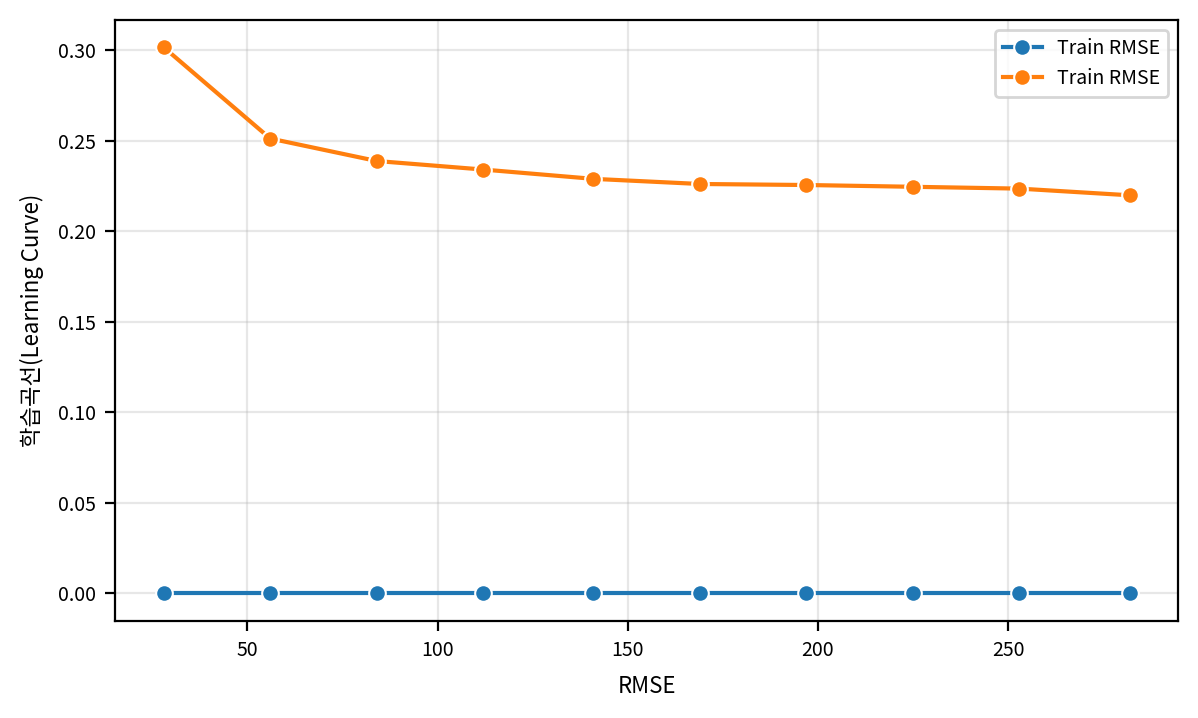

In [10]:
hs_learning_cv(best_model, x, y)

### 5. 각 변수의 중요도 판별

In [14]:
perm = permutation_importance(
    estimator=best_model,
    X=x_test,
    y=y_test,
    scoring='r2',
    n_repeats=30,
    random_state=42,
    n_jobs =-1
)

        # 결과 정리
perm_df = DataFrame(
    {
                'importance_mean': perm.importances_mean,
                'importance_std': perm.importances_std,
    },
    index = x_test.columns
).sort_values('importance_mean', ascending=False)

perm_df

,importance_mean,importance_std
weekend,0.307,0.055
holiday,0.267,0.055
marketing_cost,0.081,0.024
rain_mm,0.049,0.013
avg_price,0.015,0.011
visitors,0.014,0.011
delivery_ratio,-0.002,0.010
temperature,-0.006,0.011


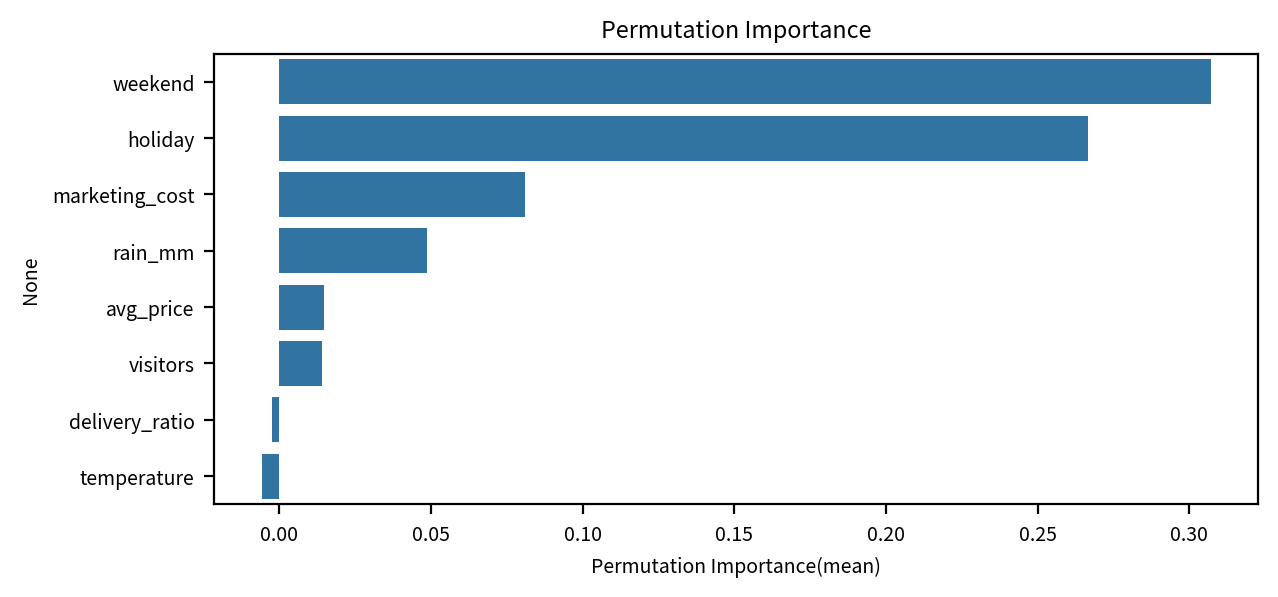

In [16]:
# 시각화
df = perm_df.sort_values(by = 'importance_mean', ascending = False)

figsize = (1280/my_dpi, 600/my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.barplot(data=df, x='importance_mean', y=df.index)

ax.set_title('Permutation Importance')
ax.set_xlabel('Permutation Importance(mean)')

plt.tight_layout()
plt.show()
plt.close()
